# Entity candidates

In [11]:
# setup
dataset_name = 'lcquad'

import os
os.chdir('/home/zola/Projects/KBQA/src')

# connect to entity catalog indexed with Lucene 
from elasticsearch import Elasticsearch
from urllib.parse import quote

class IndexSearch:
    
    def __init__(self, index_name):
        # set up ES connection
        self.es = Elasticsearch()
        self.index = index_name
        self.type = 'terms'

    def match_label(self, string, top=100):
        return self.es.search(index=self.index,
                              body={"query": {"multi_match": {"query": string,
                                                              "operator": "and",
                                                              "fields": ["label^10", "label.ngrams"],
                                                              }}},
                              size=top, doc_type=self.type)['hits']['hits']

    def look_up_by_uri(self, uri, top=1):
        results = self.es.search(index=self.index,
                              body={"query": {"term": {"uri": quote(uri, safe='():/,')}}},
                              size=top, doc_type=self.type)['hits']['hits']
        if not results:
            # fall back to label match
            return self.match_label(uri.split('/')[-1], top=1)
            
        return results


e_index = IndexSearch('dbpedia201604e')

# set up connection to the MongoDB where the QA dataset is stored
# sudo service mongod start (27017 is the default port)
from pymongo import MongoClient
import json
import pprint

class Mongo_Connector():
    '''
    Wrapper class for some of the pymongo functions: http://api.mongodb.com/python/current/tutorial.html
    '''

    def __init__(self, db_name, col_name):
        # spin up database
        self.mongo_client = MongoClient()
        self.db = self.mongo_client[db_name]
        self.col = self.db[col_name]
        print("Connection success.")
    
    def count_all_docs(self):
        count = self.col.count_documents({})
        print ("%d docs"%count)
    
    def load_json(self, json_file_path):
        with open(json_file_path, "r") as json_file:
            docs = json.load(json_file)
        dataset_size = len(docs)
        print ("%d docs"%(dataset_size))
        self.col.insert_many(docs)

    def show_example(self):
        pprint.pprint(self.col.find_one())
    
    def get_sample(self, sample_size=100):
        cursor = self.col.find()
        if sample_size:
            cursor = cursor.limit(sample_size)
        return cursor

mongo = Mongo_Connector('kbqa', dataset_name)

Connection success.


In [12]:
# load lcquad samples from MongoDB
limit = None
qas = mongo.get_sample(limit)

# prepare data for entity and predicate mention extraction models training via sequence tagging
import urllib.parse
from keras.preprocessing.text import text_to_word_sequence

questions = []
question_words = []
n_words_distr = []

correct_e_spans = []
y_e = []
correct_entities_uris = []
correct_entities_ids = []

correct_answers_uris = []
correct_answers_ids = []

print("Preparing %s dataset"%dataset_name)
for q in qas:
#     pprint.pprint(q)
    # parse question
    question_o = q['question']
    questions.append(question_o)
    words = text_to_word_sequence(question_o)
    n_words_distr.append(len(words))
    question_words.append(words)

    # generate IO tags from mention spans
    entity_spans = [e['label'].lower() for e in q['entity mapping']]
    correct_e_spans.append(entity_spans)
    y_e.append([1 if word in [entity for entity_span in entity_spans for entity in entity_span.split()] else 0 for word in words])
    
    e_uris = [e['uri'].replace("'", "") for e in q['entity mapping']]
    correct_entities_uris.append(e_uris)
    e_ids = [e_index.look_up_by_uri(uri, top=1)[0]['_source']['id'] for uri in e_uris]
    correct_entities_ids.append(e_ids)
    
    a_uris = [e_uri.replace("'", "") for e_uri in q['answers']]
    correct_answers_uris.append(a_uris)
    a_ids = []
    for uri in a_uris:
        try:
            a_ids.append(e_index.look_up_by_uri(uri, top=1)[0]['_source']['id'])
        except:
            print("%s not found in the entity catalog"%uri)
    correct_answers_ids.append(a_ids)
    
dataset_size = len(questions)
print("Loaded %d %s questions"%(dataset_size, dataset_name))

Preparing lcquad dataset
http://dbpedia.org/resource/Ys_I_&_II not found in the entity catalog
http://dbpedia.org/resource/$24_in_24 not found in the entity catalog
Loaded 2574 lcquad questions


In [13]:
# show sample question
i = 5
print(questions[i])
print(correct_e_spans[i])
print(y_e[i])
print(correct_entities_uris[i])
print(correct_entities_ids[i])
print(correct_answers_uris[i])
print(correct_answers_ids[i])

What is the common affiliation of the Monroe Carell Jr. Children's Hospital at Vanderbilt and alma mater of the Duncan U. Fletcher?
["monroe carell jr. children's hospital at vanderbilt", 'duncan u. fletcher']
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1]
['http://dbpedia.org/resource/Monroe_Carell_Jr._Childrens_Hospital_at_Vanderbilt', 'http://dbpedia.org/resource/Duncan_U._Fletcher']
[16583016, 9389949]
['http://dbpedia.org/resource/Vanderbilt_University']
[23223531]


## Correct spans

Estimate the upper bound for entity scoring function performance on the correct entity spans

In [29]:
# check if the correct entities are in the subgraph 1-hop away from the top entities
# path to KG
from hdt import HDTDocument
hdt_path = "/home/zola/Projects/hdt-cpp-molecules/libhdt/data/"
hdt_file = 'dbpedia2016-04en.hdt'
namespace = "http://dbpedia.org/"


def evaluate_entity_ranking(_e_spans, indices, top_n):
    '''
    Estimate ranking accuracy:
    n_samples <int> size of the sample questions pool
    top_n <int> threshold for the number of top entities 
    '''
    n_correct_entities, n_correct_entities_1hop = 0, 0
    n_correct_answers_1hop = 0
    # match entities
    for i in indices:
        top_e_ids = []
        
        # entities index lookup
        for span in _e_spans[i]:
            for match in e_index.match_label(span, top=top_n):
                top_e_ids.append(match['_source']['id'])
        
        if set(correct_entities_ids[i]).issubset(set(top_e_ids)):
            n_correct_entities += 1
        
        # extract a subgraph for top entities
        kg = HDTDocument(hdt_path+hdt_file)
        # all predicates: 1 hop
        kg.configure_hops(1, [], namespace, True)
        entities, _, _ = kg.compute_hops(top_e_ids)
        if set(correct_entities_ids[i]).issubset(set(entities)):
            n_correct_entities_1hop += 1
        if set(correct_answers_ids[i]).issubset(set(entities)):
            n_correct_answers_1hop += 1
        kg.remove()


    r_entities = float(n_correct_entities) / n_samples
    r_entities_1hop = float(n_correct_entities_1hop) / n_samples
    r_answers_1hop = float(n_correct_answers_1hop) / n_samples
    
    return [r_entities, r_entities_1hop, r_answers_1hop]


# define sample size for evaluation
n_samples = 500
top_n_range = [1, 5]
print("Entity match recall estimated on %d questions @%d"%(n_samples, top_n_range[1]))
# shuffle dataset to get a random sample
from random import shuffle
index_shuf = list(range(dataset_size))
shuffle(index_shuf)
index_shuf = index_shuf[:n_samples]
assert len(index_shuf) == n_samples

Entity match recall estimated on 500 questions @5


       0      1      2
0  0.000  0.000  0.000
1  0.528  0.746  0.700
2  0.666  0.836  0.776
3  0.716  0.854  0.798
4  0.738  0.878  0.808
5  0.762  0.892  0.814


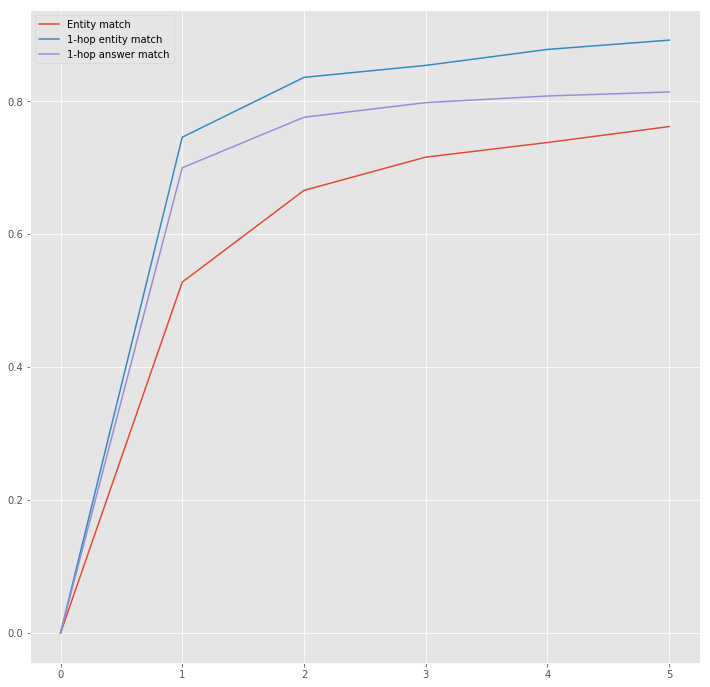

In [30]:
# evaluate on correct entity spans
top_n = top_n_range[0]
results = [[0, 0, 0]]  # recalls at 0
while top_n <= top_n_range[1]:
    results.append(evaluate_entity_ranking(correct_e_spans, index_shuf, top_n))
    top_n += 1
    
# show result
import pandas as pd
results = pd.DataFrame(results)
print(results)

# plot
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(results[0], label='Entity match')
plt.plot(results[1], label='1-hop entity match')
plt.plot(results[2], label='1-hop answer match')
plt.legend()
plt.show()

## Extracted spans

Estimate performance on the extracted entity spans using the mention extraction model

In [18]:
# load pre-trained entity mention extraction model
embeddings_choice = 'glove6B100d'

from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras.optimizers import Adam

def build_model(model_settings):
    # architecture
    input = Input(shape=(model_settings['max_len'],))
    model = Embedding(input_dim=model_settings['n_words']+1, output_dim=model_settings['emb_dim'],
                      weights=[model_settings['embeddings']],
                      input_length=model_settings['max_len'], mask_zero=True, trainable=False)(input)
    model = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.1))(model)  # variational biLSTM
    model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
    crf = CRF(model_settings['n_tags'])  # CRF layer
    out = crf(model)  # output
    model = Model(input, out)
    model.compile(optimizer=Adam(lr=0.0001), loss=crf.loss_function, metrics=[crf.accuracy])
    model.summary()
    return model

# load model settings
import pickle as pkl
with open('%s_%s.pkl'%(dataset_name, embeddings_choice), 'rb') as f:
    model_settings = pkl.load(f)
model = build_model(model_settings)

# load weights
model_name = 'entity_model'
model.load_weights('model/'+model_name+'.h5')

/home/zola/anaconda3/envs/tf36/lib/python3.6/site-packages/keras_contrib/layers/crf.py:314: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated and it might be removed in the future. Please '
/home/zola/anaconda3/envs/tf36/lib/python3.6/site-packages/keras_contrib/layers/crf.py:320: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it might be removed in the future. Please '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 25)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 25, 100)           711400    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 25, 100)           60400     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 25, 50)            5050      
_________________________________________________________________
crf_2 (CRF)                  (None, 25, 2)             110       
Total params: 776,960
Trainable params: 65,560
Non-trainable params: 711,400
_________________________________________________________________


In [19]:
# evaluate entity span detection
import numpy as np
from keras.preprocessing.sequence import pad_sequences

def evaluate_entity_span_extraction(show_errors=False):
    n_correct = 0
    questions_e_spans = []
    for i, words in enumerate(question_words):
        x_test_sent = pad_sequences(sequences=[[model_settings['word2idx'].get(w, 'unk') for w in words]],
                                    padding="post", value=0, maxlen=model_settings['max_len'])
        p = model.predict(np.array([x_test_sent[0]]))
        p = np.argmax(p, axis=-1)[0]

        e_span, e_spans = [], []
        for w, pred in zip(words, p):
            if pred > 0:
                e_span.append(w)
            elif e_span:
                e_spans.append(" ".join(e_span))
                e_span = []
        # add last span
        if e_span:
            e_spans.append(" ".join(e_span))
            e_span = []

        if set(correct_e_spans[i]) == set(e_spans):
            n_correct += 1
        elif show_errors:
            print('\n')
            print(set(e_spans))
            # show correct spans
            print(set(correct_e_spans[i]))
        questions_e_spans.append(e_spans)
    p = float(n_correct) / dataset_size
    print("\nAcc: %.2f "%(p))
    return questions_e_spans

# evaluate
print("Accuracy estimated on %d questions"%(dataset_size))
extracted_e_spans = evaluate_entity_span_extraction()

Accuracy estimated on 2574 questions

Acc: 0.52 


       0      1      2
0  0.000  0.000  0.000
1  0.416  0.608  0.610
2  0.520  0.694  0.680
3  0.558  0.718  0.700
4  0.574  0.732  0.714
5  0.596  0.750  0.724


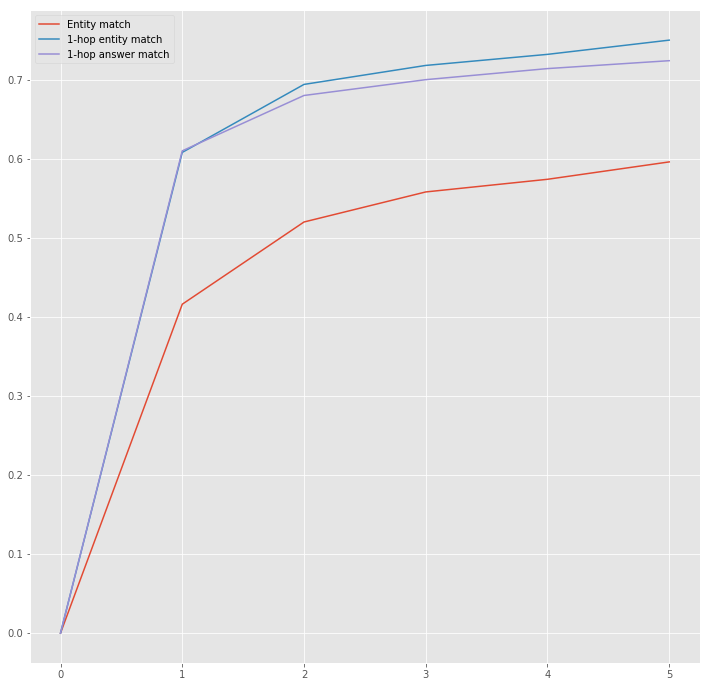

In [31]:
# evaluate on correct entity spans
top_n = top_n_range[0]
results = [[0, 0, 0]]  # recalls at 0
while top_n <= top_n_range[1]:
    results.append(evaluate_entity_ranking(extracted_e_spans, index_shuf, top_n))
    top_n += 1
    
# show result
import pandas as pd
results = pd.DataFrame(results)
print(results)

# plot
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(results[0], label='Entity match')
plt.plot(results[1], label='1-hop entity match')
plt.plot(results[2], label='1-hop answer match')
plt.legend()
plt.show()